# 01 - Exploratory Data Analysis

In [1]:
import sys
import os
from copy import deepcopy

import numpy as np
import pandas as pd
import seaborn as sn

# time series specific
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sktime.utils.plotting import plot_series
from sktime.distances.elastic import dtw_distance

from pprint import pprint

# warnings
import warnings
warnings.filterwarnings('ignore')

print("Versions:")
print(f" - python {sys.version.split()[0]}")
print(f" - pandas {pd.__version__}")
print(f" - numpy {np.__version__}")

Versions:
 - python 3.8.5
 - pandas 1.3.3
 - numpy 1.21.2


## The Data

*insert data description*

In [2]:
main_df = pd.read_csv("../DATA/ILINet.csv", na_values="X")

In [3]:
display(main_df.head())
print(main_df.info())

,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,Alabama,2010,40,NaN,2.134770,249.0,35.0,11664.0
1,Alaska,2010,40,NaN,0.875146,15.0,7.0,1714.0
2,Arizona,2010,40,NaN,0.674721,172.0,49.0,25492.0
3,Arkansas,2010,40,NaN,0.696056,18.0,15.0,2586.0
4,California,2010,40,NaN,1.954120,632.0,112.0,32342.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30948 entries, 0 to 30947
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   REGION             30948 non-null  object 
 1   YEAR               30948 non-null  int64  
 2   WEEK               30948 non-null  int64  
 3   % WEIGHTED ILI     64 non-null     float64
 4   %UNWEIGHTED ILI    30268 non-null  float64
 5   ILITOTAL           30268 non-null  float64
 6   NUM. OF PROVIDERS  30268 non-null  float64
 7   TOTAL PATIENTS     30268 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 1.9+ MB
None


In [4]:
# Some additional info
print("The dataset contains:")
regions = list(main_df["REGION"].unique())
print(f" - {len(regions)} states")
years = list(main_df["YEAR"].unique())
print(f" - {len(years)} years")

# checking cause a lot of ILI datsets only have data for the flu season weeks
weeks = list(main_df["WEEK"].unique())
print(f" - {len(weeks)} weeks per year")

The dataset contains:
 - 55 states
 - 12 years
 - 53 weeks per year


## Dates

Create a new column that represents the date
formats for week:
* **%U:** Week number of the year (Sunday as the first day of the week) as a zero padded decimal number. All days in a new year preceding the first Sunday are considered to be in week 0
* **%W:** Week number of the year (Monday as the first day of the week) as a decimal number. All days in a new year preceding the first Monday are considered to be in week 0.
* **%V:** ISO 8601 week as a decimal number with Monday as the first day of the week. Week 01 is the week containing Jan 4.  

(from: https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes)

**ISO years with 53 weeks:**
![iso_weeks](./images/01_iso_weeks.png)

In [5]:
# check for weird
temp_df = main_df[["YEAR", "WEEK"]].drop_duplicates()
print("Week range:")
print(temp_df["WEEK"].min(), temp_df["WEEK"].max())
temp_df = temp_df[temp_df["WEEK"] == 53]
display(temp_df)

Week range:
1 53


,YEAR,WEEK
11726,2014,53
28693,2020,53


In [6]:
main_df["ds_wsun"] = pd.to_datetime(
    main_df["YEAR"].apply(str) + "-" + main_df["WEEK"].apply(str) + "-" + "7",
    format="%G-%V-%u"
)

In [7]:
np.all(main_df["ds_wsun"].dt.isocalendar()["year"] == main_df["YEAR"])

False

In [8]:
np.all(main_df["ds_wsun"].dt.isocalendar()["week"] == main_df["WEEK"])

False

In [9]:
main_df[~(main_df["ds_wsun"].dt.isocalendar()["year"] == main_df["YEAR"])].head()

,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,ds_wsun
11726,Alabama,2014,53,NaN,11.22120,1008.0,24.0,8983.0,2015-01-04
11727,Alaska,2014,53,NaN,2.36626,23.0,6.0,972.0,2015-01-04
11728,Arizona,2014,53,NaN,2.65764,424.0,59.0,15954.0,2015-01-04
11729,Arkansas,2014,53,NaN,5.00131,191.0,19.0,3819.0,2015-01-04
11730,California,2014,53,NaN,4.77128,1284.0,152.0,26911.0,2015-01-04


In [10]:
(main_df[main_df["REGION"]=="New York City"]
    [main_df[main_df["REGION"]=="New York City"]["ds_wsun"]
      .duplicated(keep=False)]
)

,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,ds_wsun
11779,New York City,2014,53,NaN,3.45710,3269.0,66.0,94559.0,2015-01-04
11833,New York City,2015,1,NaN,2.97957,3029.0,93.0,101659.0,2015-01-04


The CDC has its own week convention called **MMWR** for epidemiological weeks.  
Luckily there is a package for that:  
https://github.com/dralshehri/epiweeks

In [11]:
import epiweeks as epi

print(epi.Week(2014, 53).enddate())
print(epi.Week(2015, 1).enddate())

2015-01-03
2015-01-10


In [12]:
def epiweeks_from_df(year_week_row):
    """
    Takes an array of the form (year, week) and returns the MMWR week end-dat (Sunday)
    """
    return epi.Week(year_week_row[0], year_week_row[1]).enddate()

main_df["ds_wsun"] = main_df[["YEAR", "WEEK"]].apply(epiweeks_from_df, axis=1)
main_df["ds_wsun"] = pd.to_datetime(main_df["ds_wsun"])

In [13]:
(main_df[main_df["REGION"]=="New York City"]
    [main_df[main_df["REGION"]=="New York City"]["ds_wsun"]
      .duplicated(keep=False)]
)

,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,ds_wsun


## Data Validation

**Checks for:**
* missing dates
* duplicated dates
* nulls
* zeros

In [14]:
# duplicated weeks

In [15]:
# missing weeks

In [16]:
# null values
nas = np.sum(main_df["ILITOTAL"].isna()*1)
print(f"The dataset has {nas} nulls")

The dataset has 680 nulls


In [17]:
null_regions = list(main_df[main_df["ILITOTAL"].isna()]["REGION"].unique())
print("The following regions contain nulls:")
print(null_regions)

The following regions contain nulls:
['Florida', 'Commonwealth of the Northern Mariana Islands']


In [18]:
# zeros
zeros = np.sum((main_df["ILITOTAL"] == 0)*1)
print(f"The dataset has {zeros} zeros")

The dataset has 975 zeros


In [19]:
main_df["ds_wsun"].max()

Timestamp('2021-10-09 00:00:00')

## Filter Data

In [20]:
start_date = "01-01-2010"
end_date = main_df["ds_wsun"].max()


main_df = main_df[
    (~main_df["REGION"].isin(null_regions)) & 
    (main_df["ds_wsun"] >= start_date) &
    (main_df["ds_wsun"] <= end_date)
]

regions = list(main_df["REGION"].unique())

## Casual plotting

In [21]:
from ipywidgets import widgets
import seaborn as sn
from matplotlib import pyplot as plt

plt.rcParams.update({'figure.figsize': (30,20)})

In [22]:
def plot_regions(
    df, 
    regions_list,
    y_col="ILITOTAL",
    start_date="01-01-2013", 
    end_date="01-01-2020", 
    region_col="REGION", 
    date_col="ds_wsun"
):
    df = df.copy()
    df = df[
        df[region_col].isin(regions_list) & 
        (df[date_col] >= start_date) &
        (df[date_col] <= end_date)
    ]
    for region, ts in df.groupby(region_col, as_index=False):
        plt.plot(ts[date_col], ts[y_col])
        
    plt.show()

In [23]:
_ = widgets.interact(
    plot_regions, 
    df=widgets.fixed(main_df),
    regions_list=widgets.SelectMultiple(options=regions, value=["California"], disabled=False),
    y_col=widgets.Dropdown(
        options=["ILITOTAL", "TOTAL PATIENTS", "%UNWEIGHTED ILI", "% WEIGHTED ILI"]
    ),
    region_col=widgets.fixed("REGION"),
    date_col=widgets.fixed("ds_wsun"),
)

interactive(children=(SelectMultiple(description='regions_list', index=(4,), options=('Alabama', 'Alaska', 'Ar…

## Time series similarities

**Correlations between time series**

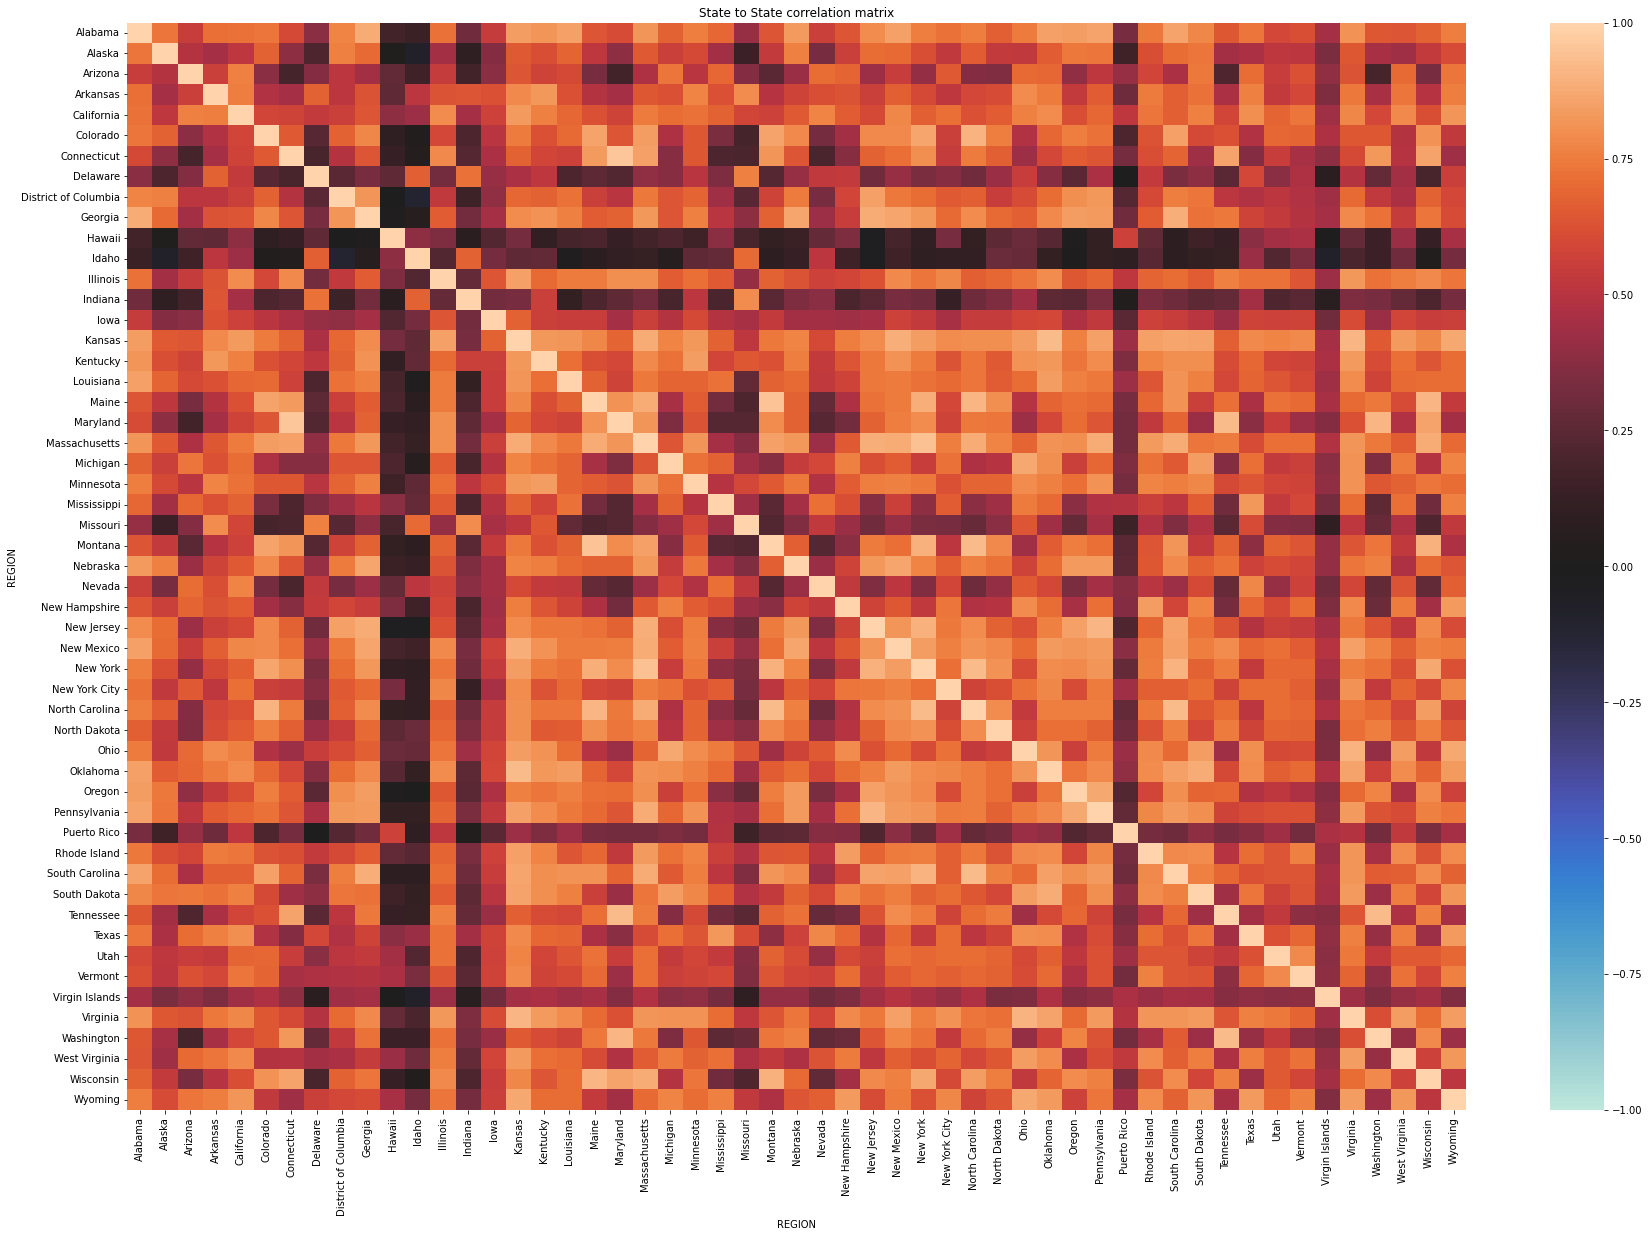

In [24]:
piv_df = pd.pivot(main_df, index="ds_wsun", columns="REGION", values="ILITOTAL")
sn.heatmap(piv_df.corr(), vmin=-1 ,vmax=1, center=0)
plt.title("State to State correlation matrix")
plt.show()

**Dynamic time warping**

In [25]:
# regions_list = deepcopy(regions)
# dtw_df = pd.DataFrame()

# for state1 in regions_list:
#     ts1 = main_df[main_df["REGION"]==state1]["ILITOTAL"].to_numpy().T
#     for state2 in regions_list:
#         ts2 = main_df[main_df["REGION"]==state2]["ILITOTAL"].to_numpy().T
        
#         d = dtw_distance(ts1, ts2)
#         dtw_row = {"state1":state1, "state2":state2, "dtw_distance": d}
#         dtw_df = dtw_df.append(dtw_row, ignore_index=True)
#         # might need to do regions_list.remove(state1) at the end
#     regions_list.remove(state1)

# piv_df = pd.pivot(dtw_df, index="state1", columns="state2", values="dtw_distance")
# sn.heatmap(piv_df)
# plt.title("State to State dtw distance matrix")
# plt.show()

**ts features**

In [26]:
# code here

## Single time series analysis

In [53]:
start_date = "2013-01-01"
end_date = "2020-01-01"

ts_df = main_df[
    (main_df["REGION"]=="California") & 
    (main_df["ds_wsun"] >= start_date) &
    (main_df["ds_wsun"] <= end_date)
]

**Seasonal plots**

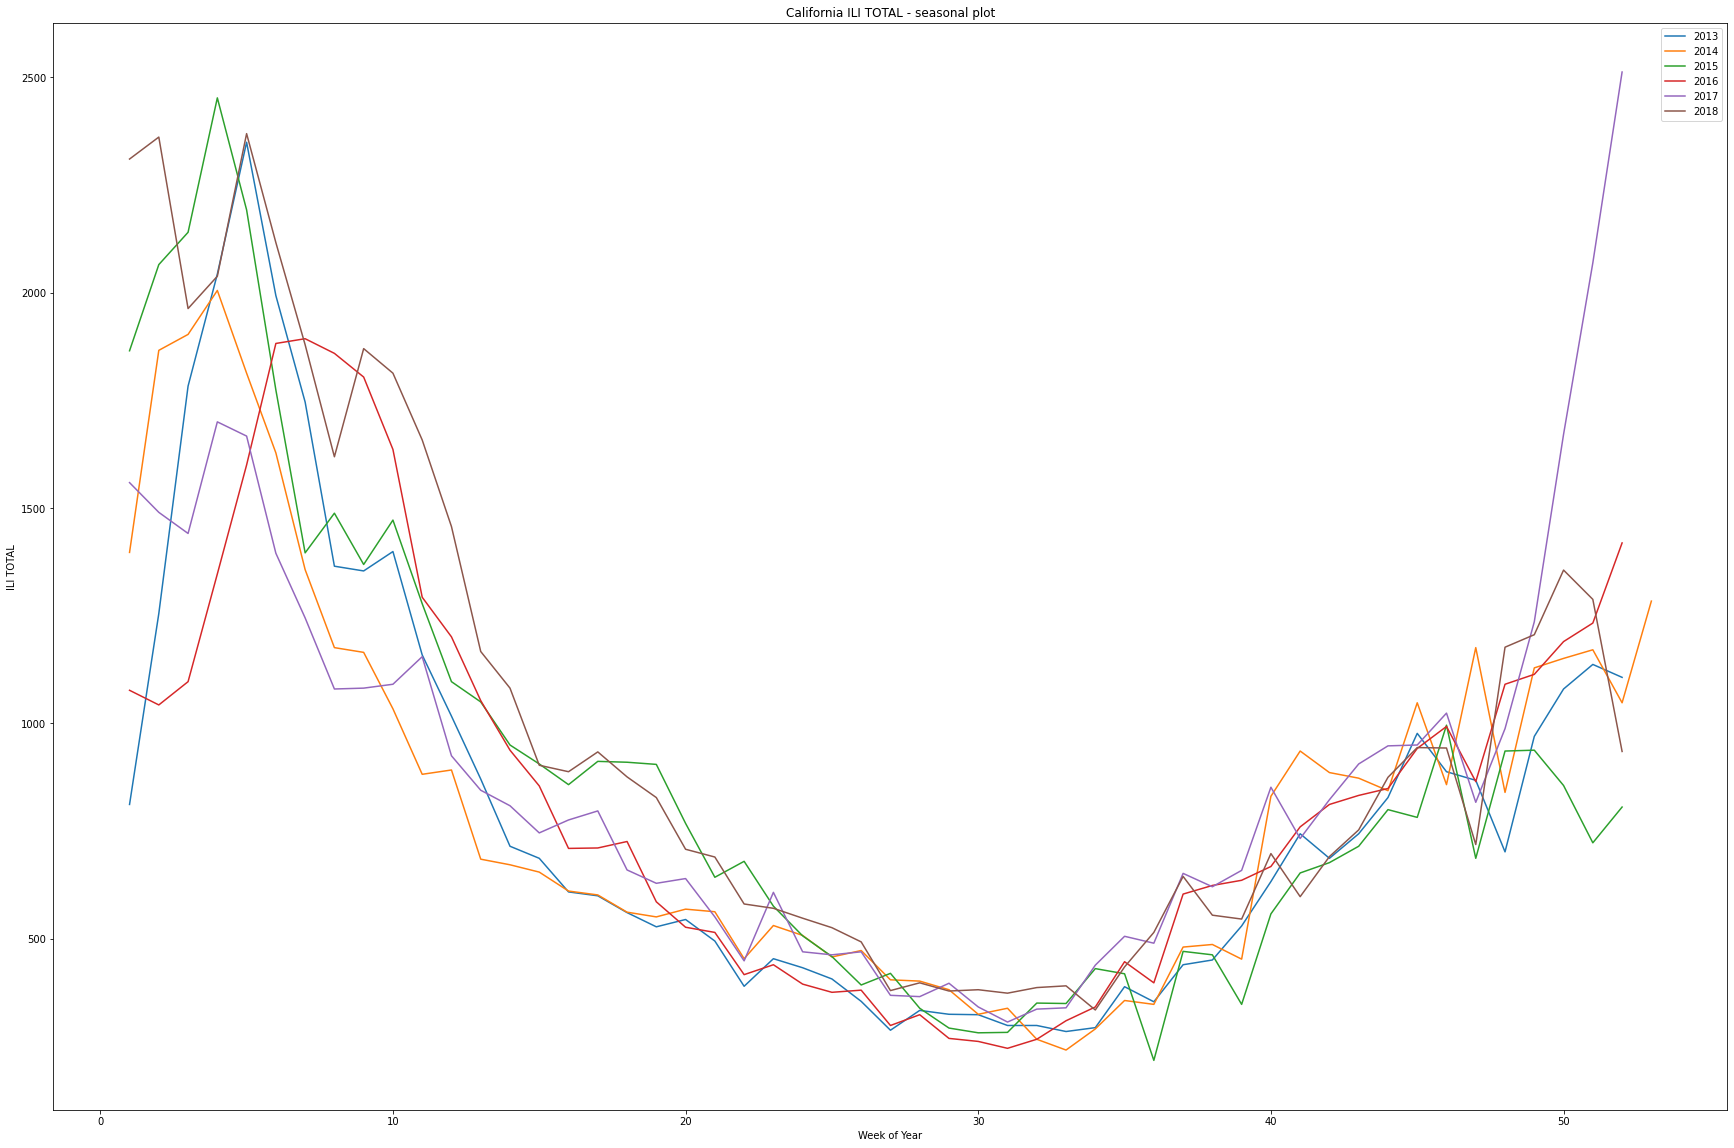

In [54]:
for year in range(2013, 2019):
    temp_df = ts_df[ts_df["YEAR"]==year]
    plt.plot(temp_df["WEEK"], temp_df["ILITOTAL"], label=year)  
plt.title("California ILI TOTAL - seasonal plot")
plt.xlabel("Week of Year")
plt.ylabel("ILI TOTAL")
plt.legend()
plt.show()

**Autocorrelation plot**

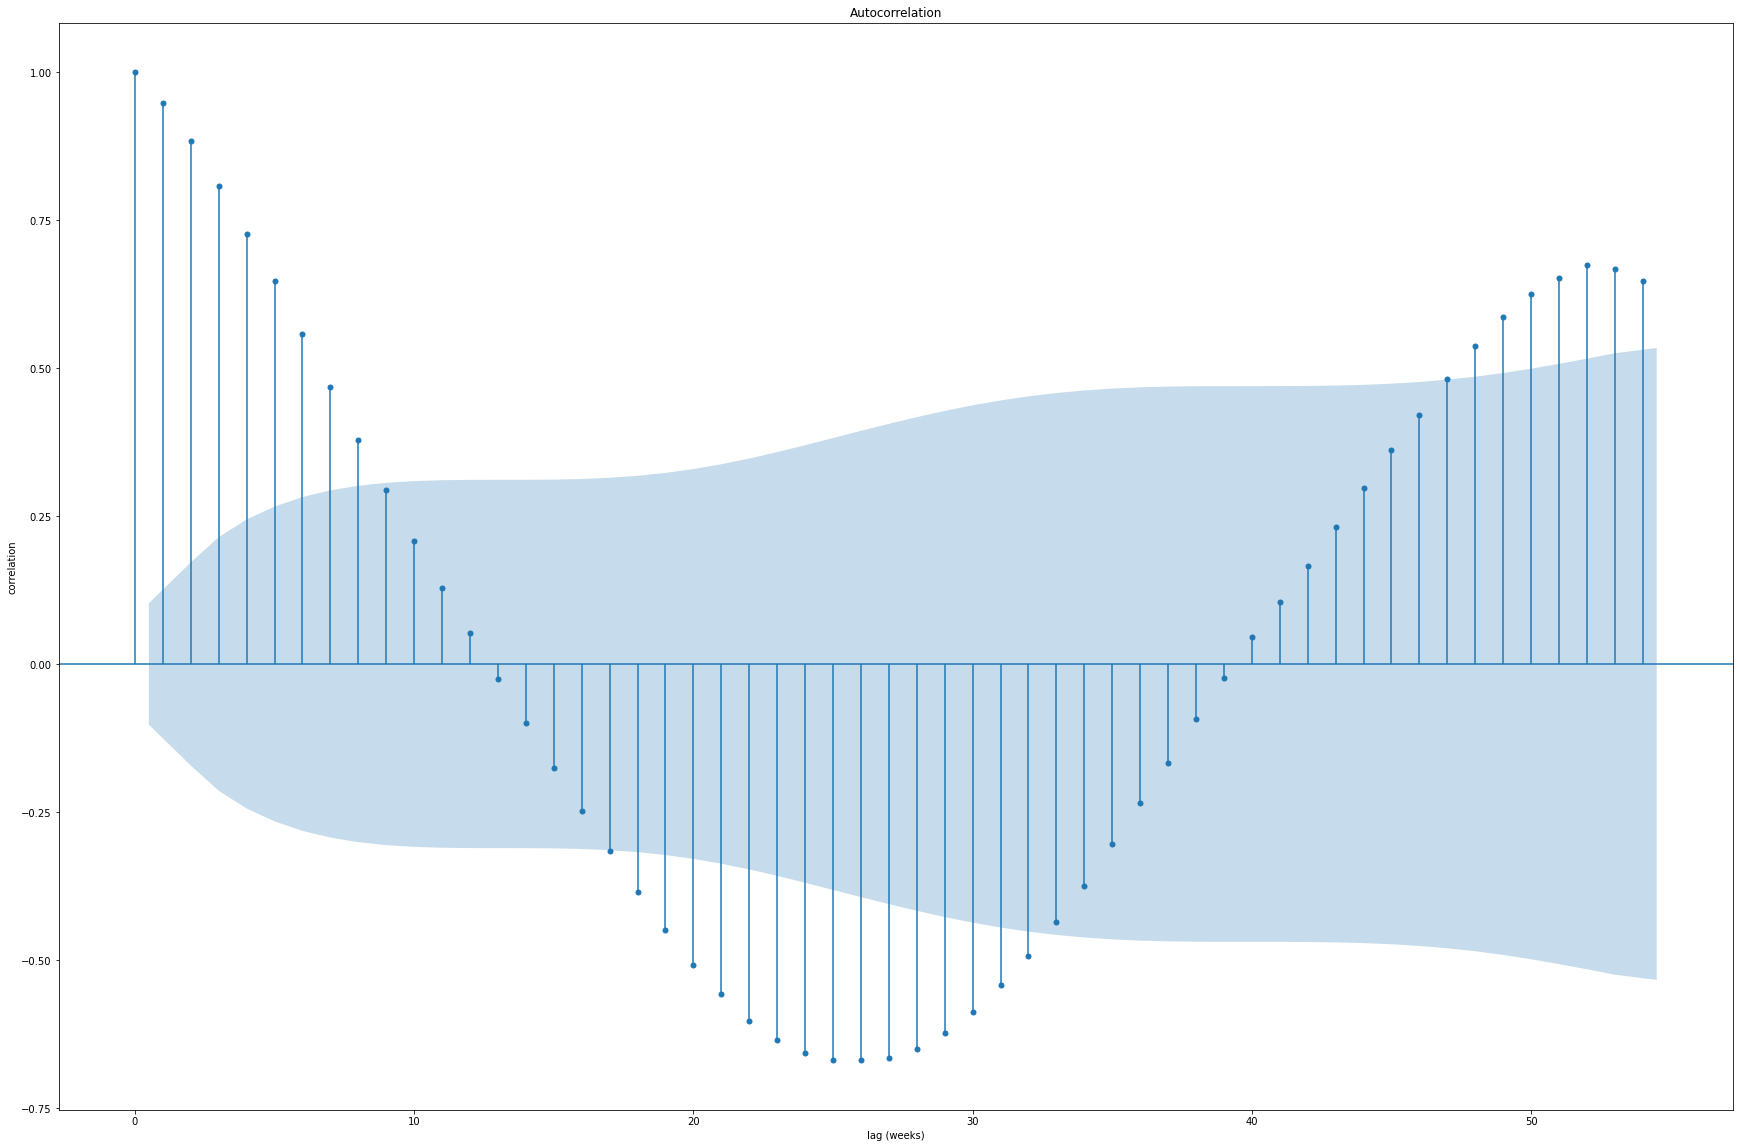

In [55]:
plot_acf(ts_df["ILITOTAL"], lags=54)
plt.xlabel("lag (weeks)")
plt.ylabel("correlation")
plt.show()

**Multiplicative seasonality**
https://kourentzes.com/forecasting/2014/11/09/additive-and-multiplicative-seasonality/

**Decomposition with moving averages**

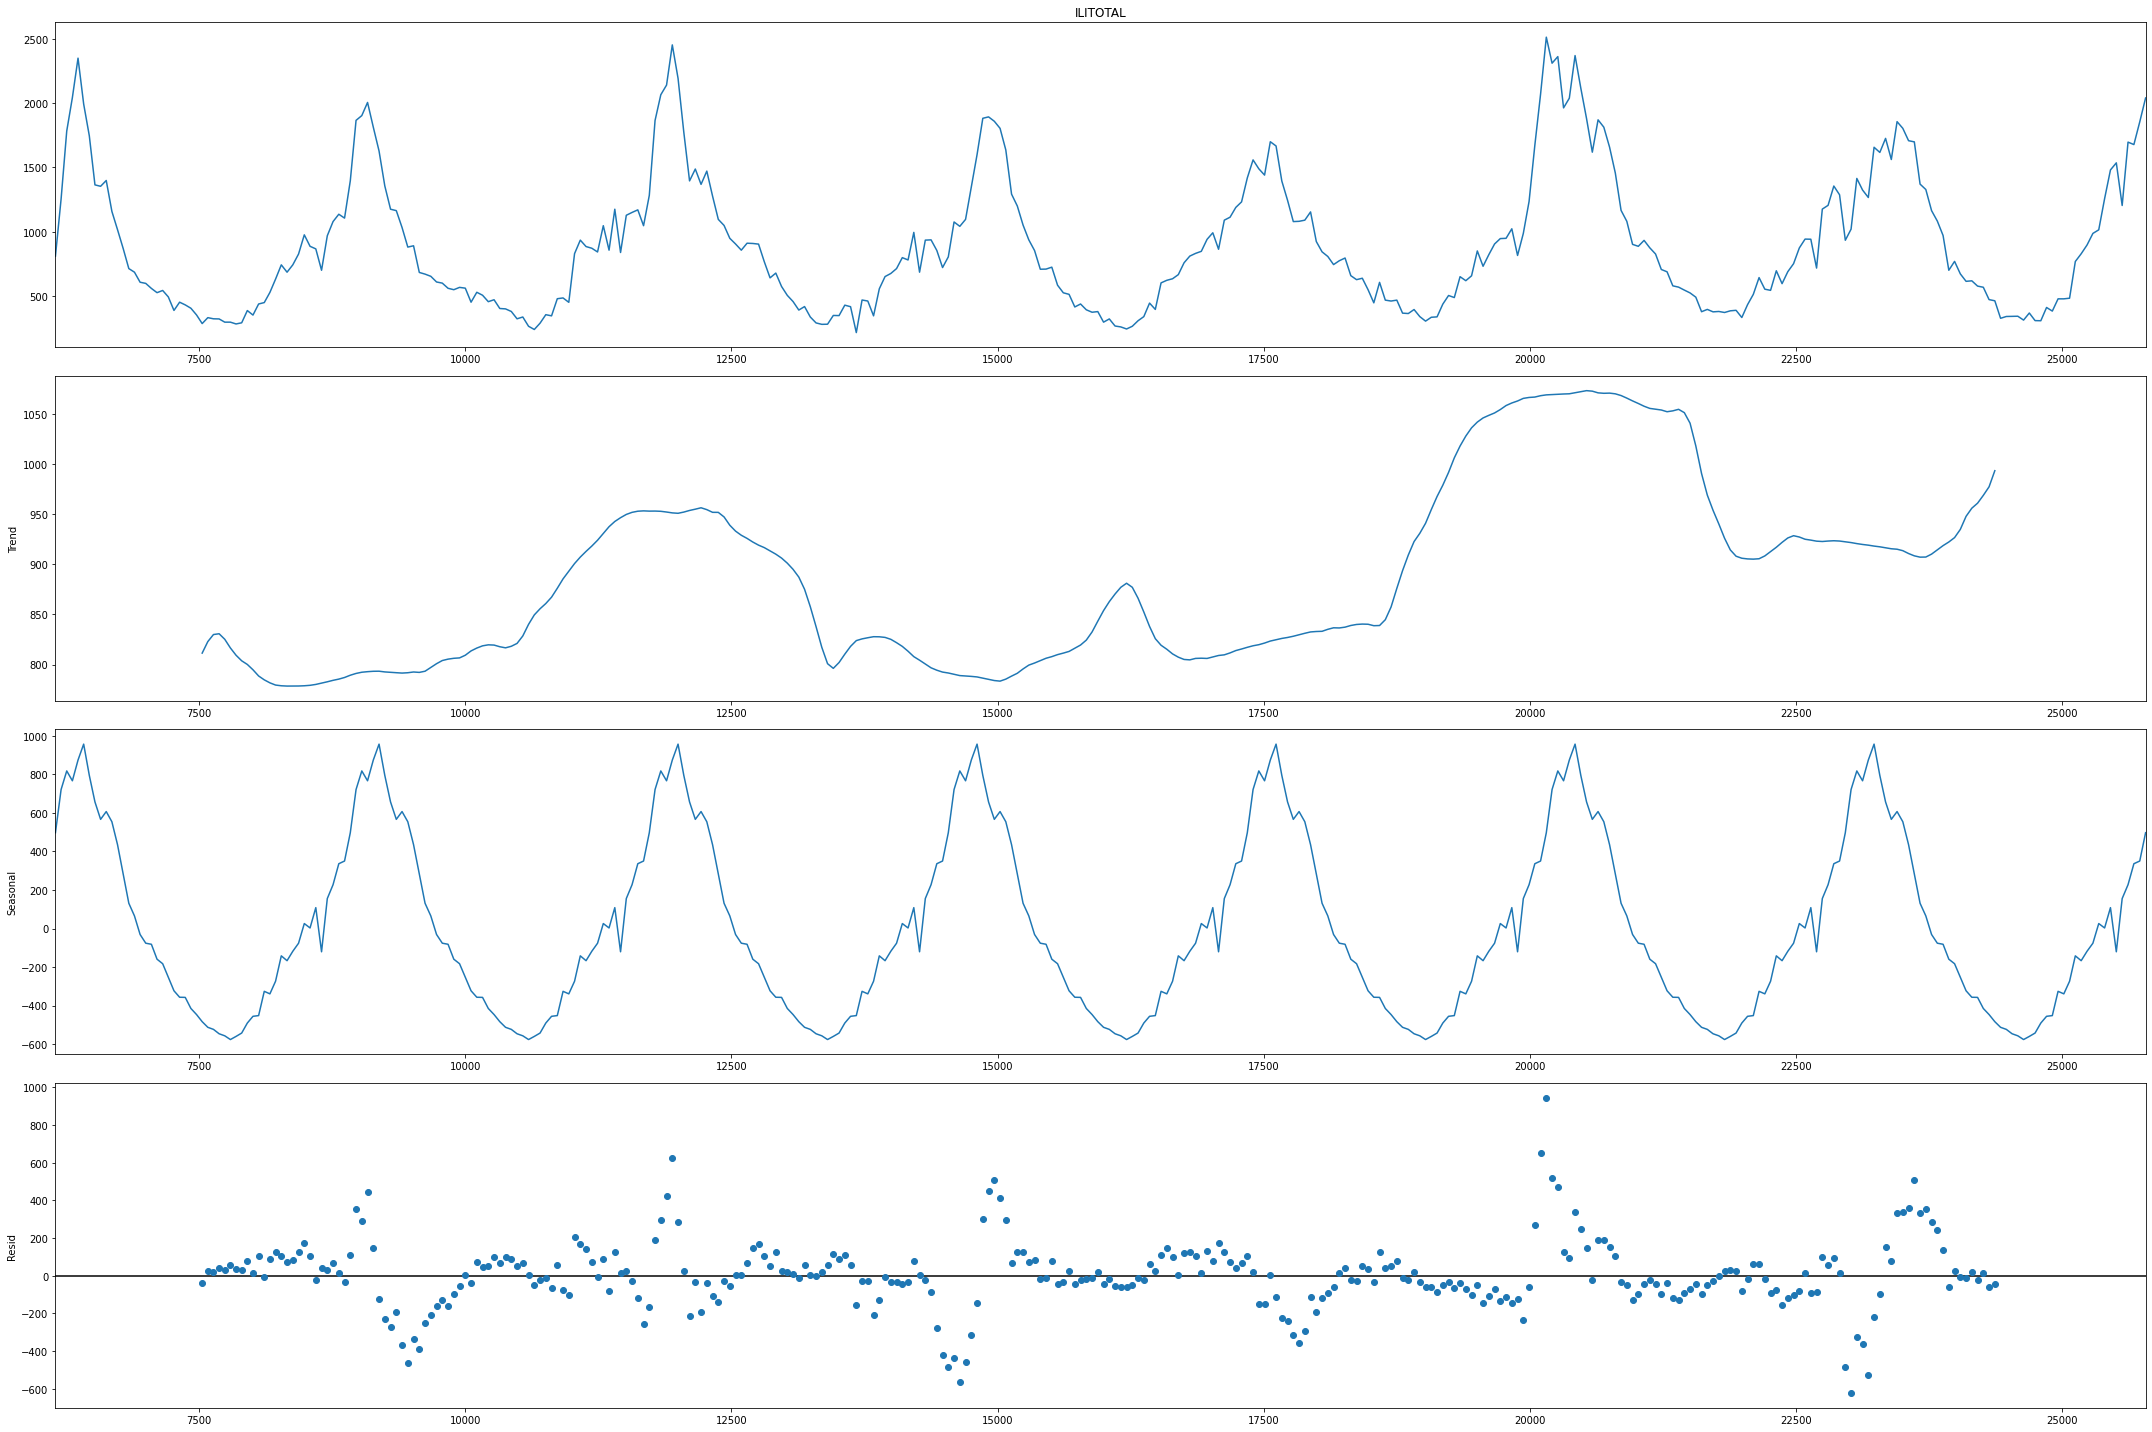

In [56]:
res = seasonal_decompose(ts_df["ILITOTAL"], model='additive', period=52)
res.plot()
plt.show()

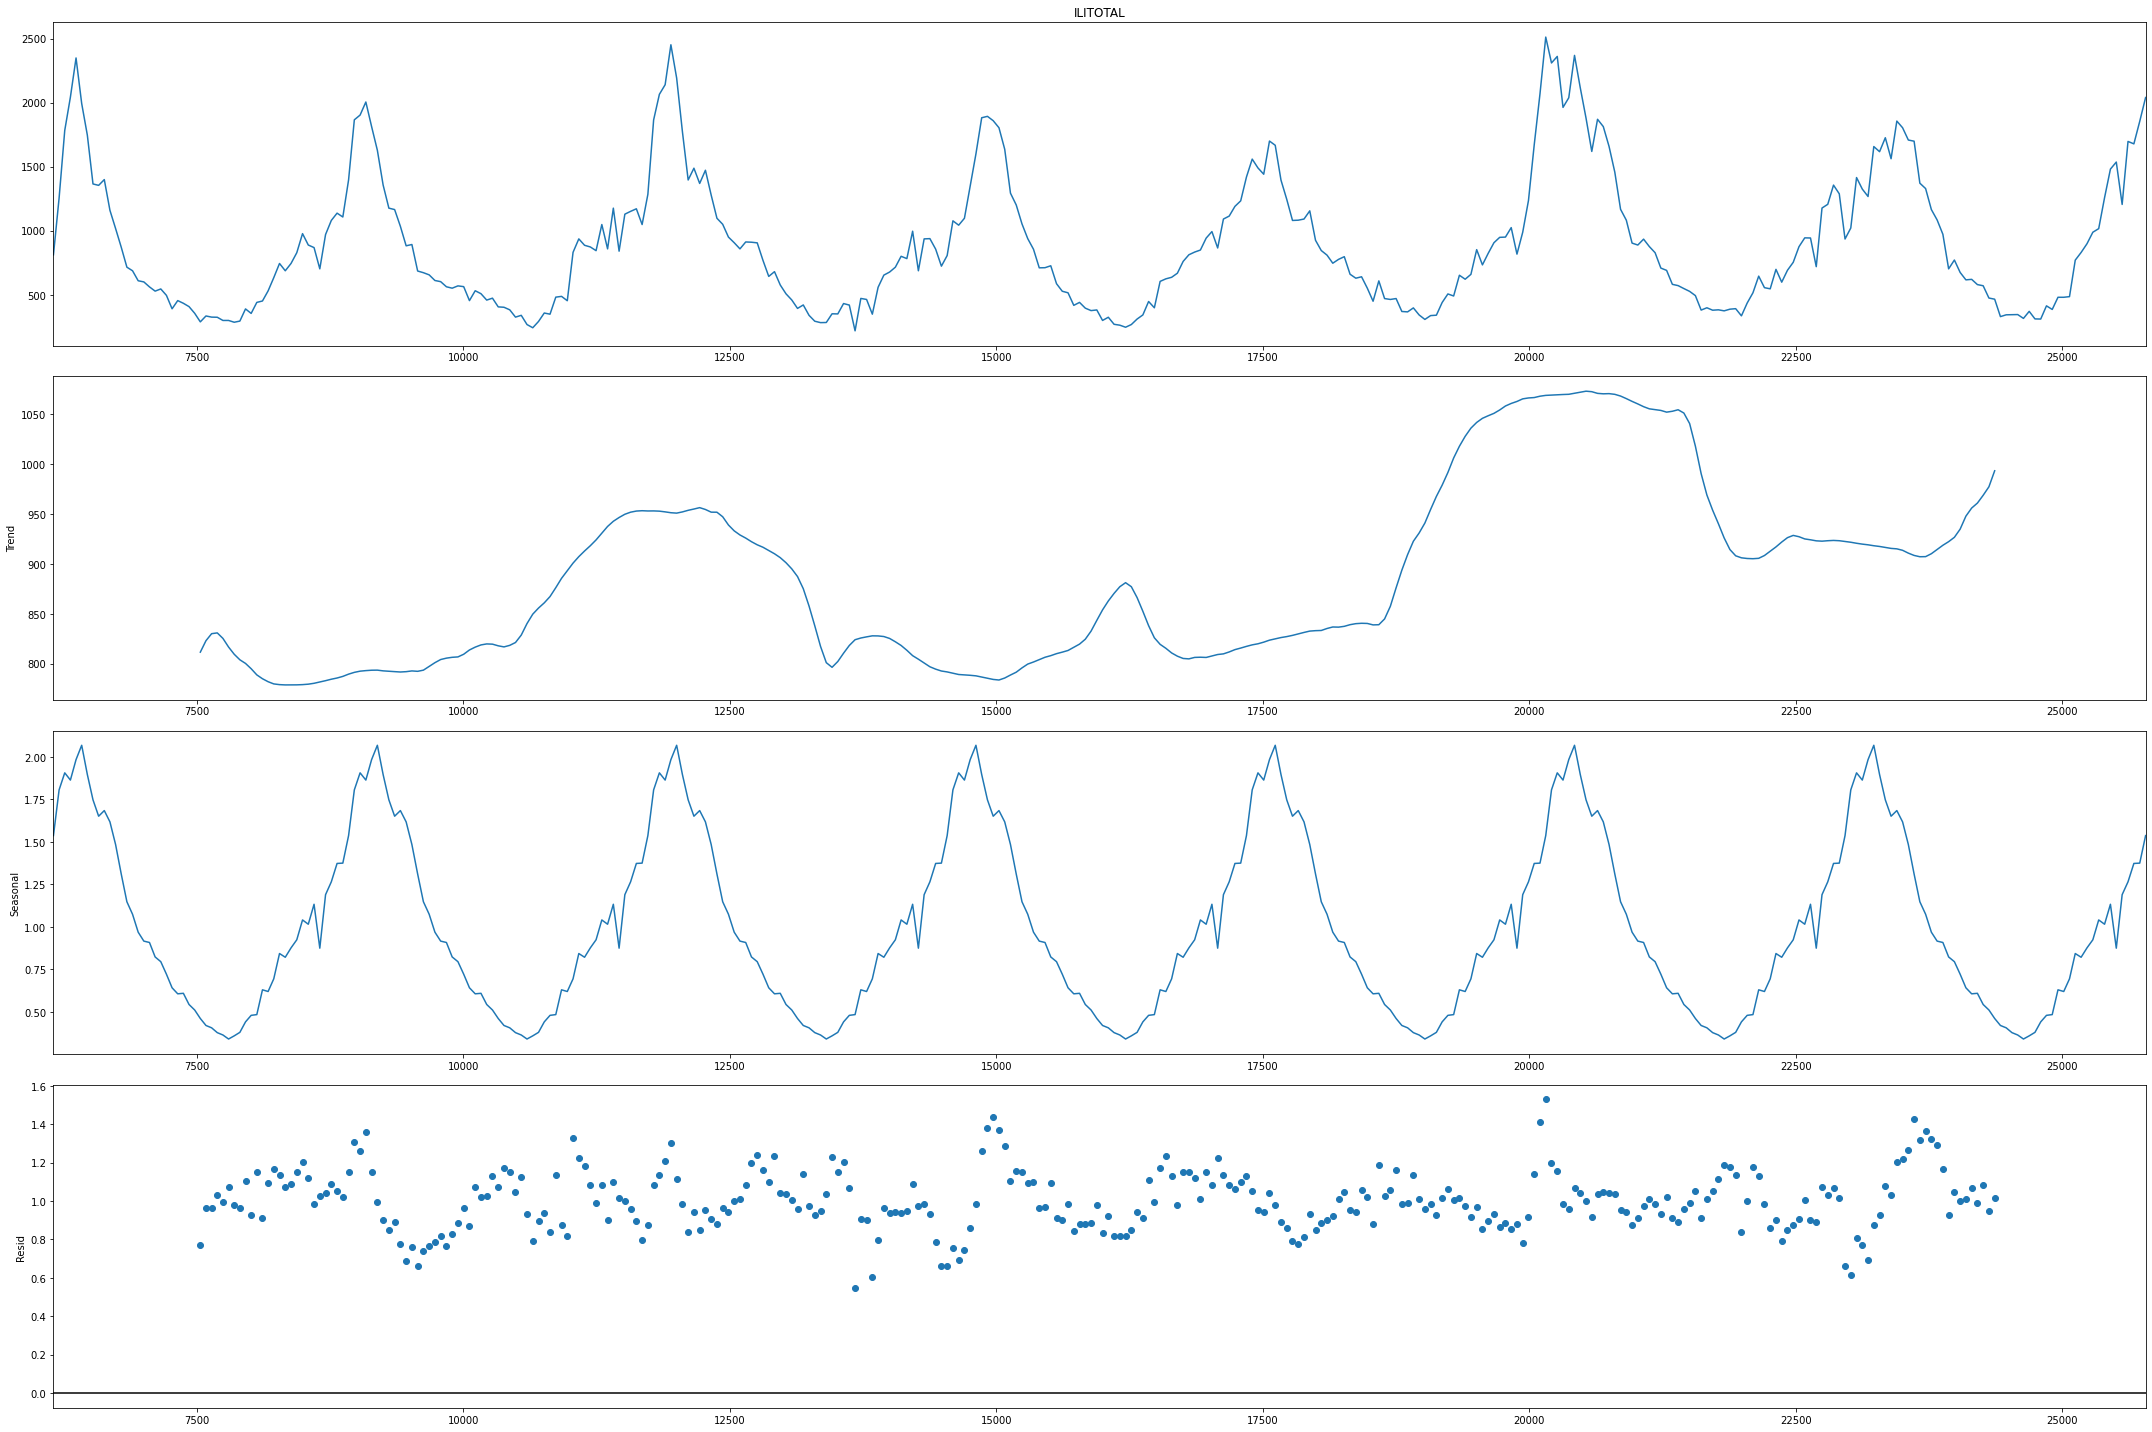

In [57]:
res = seasonal_decompose(ts_df["ILITOTAL"], model='multiplicative', period=52)
res.plot()
plt.show()

**STL decomposition**

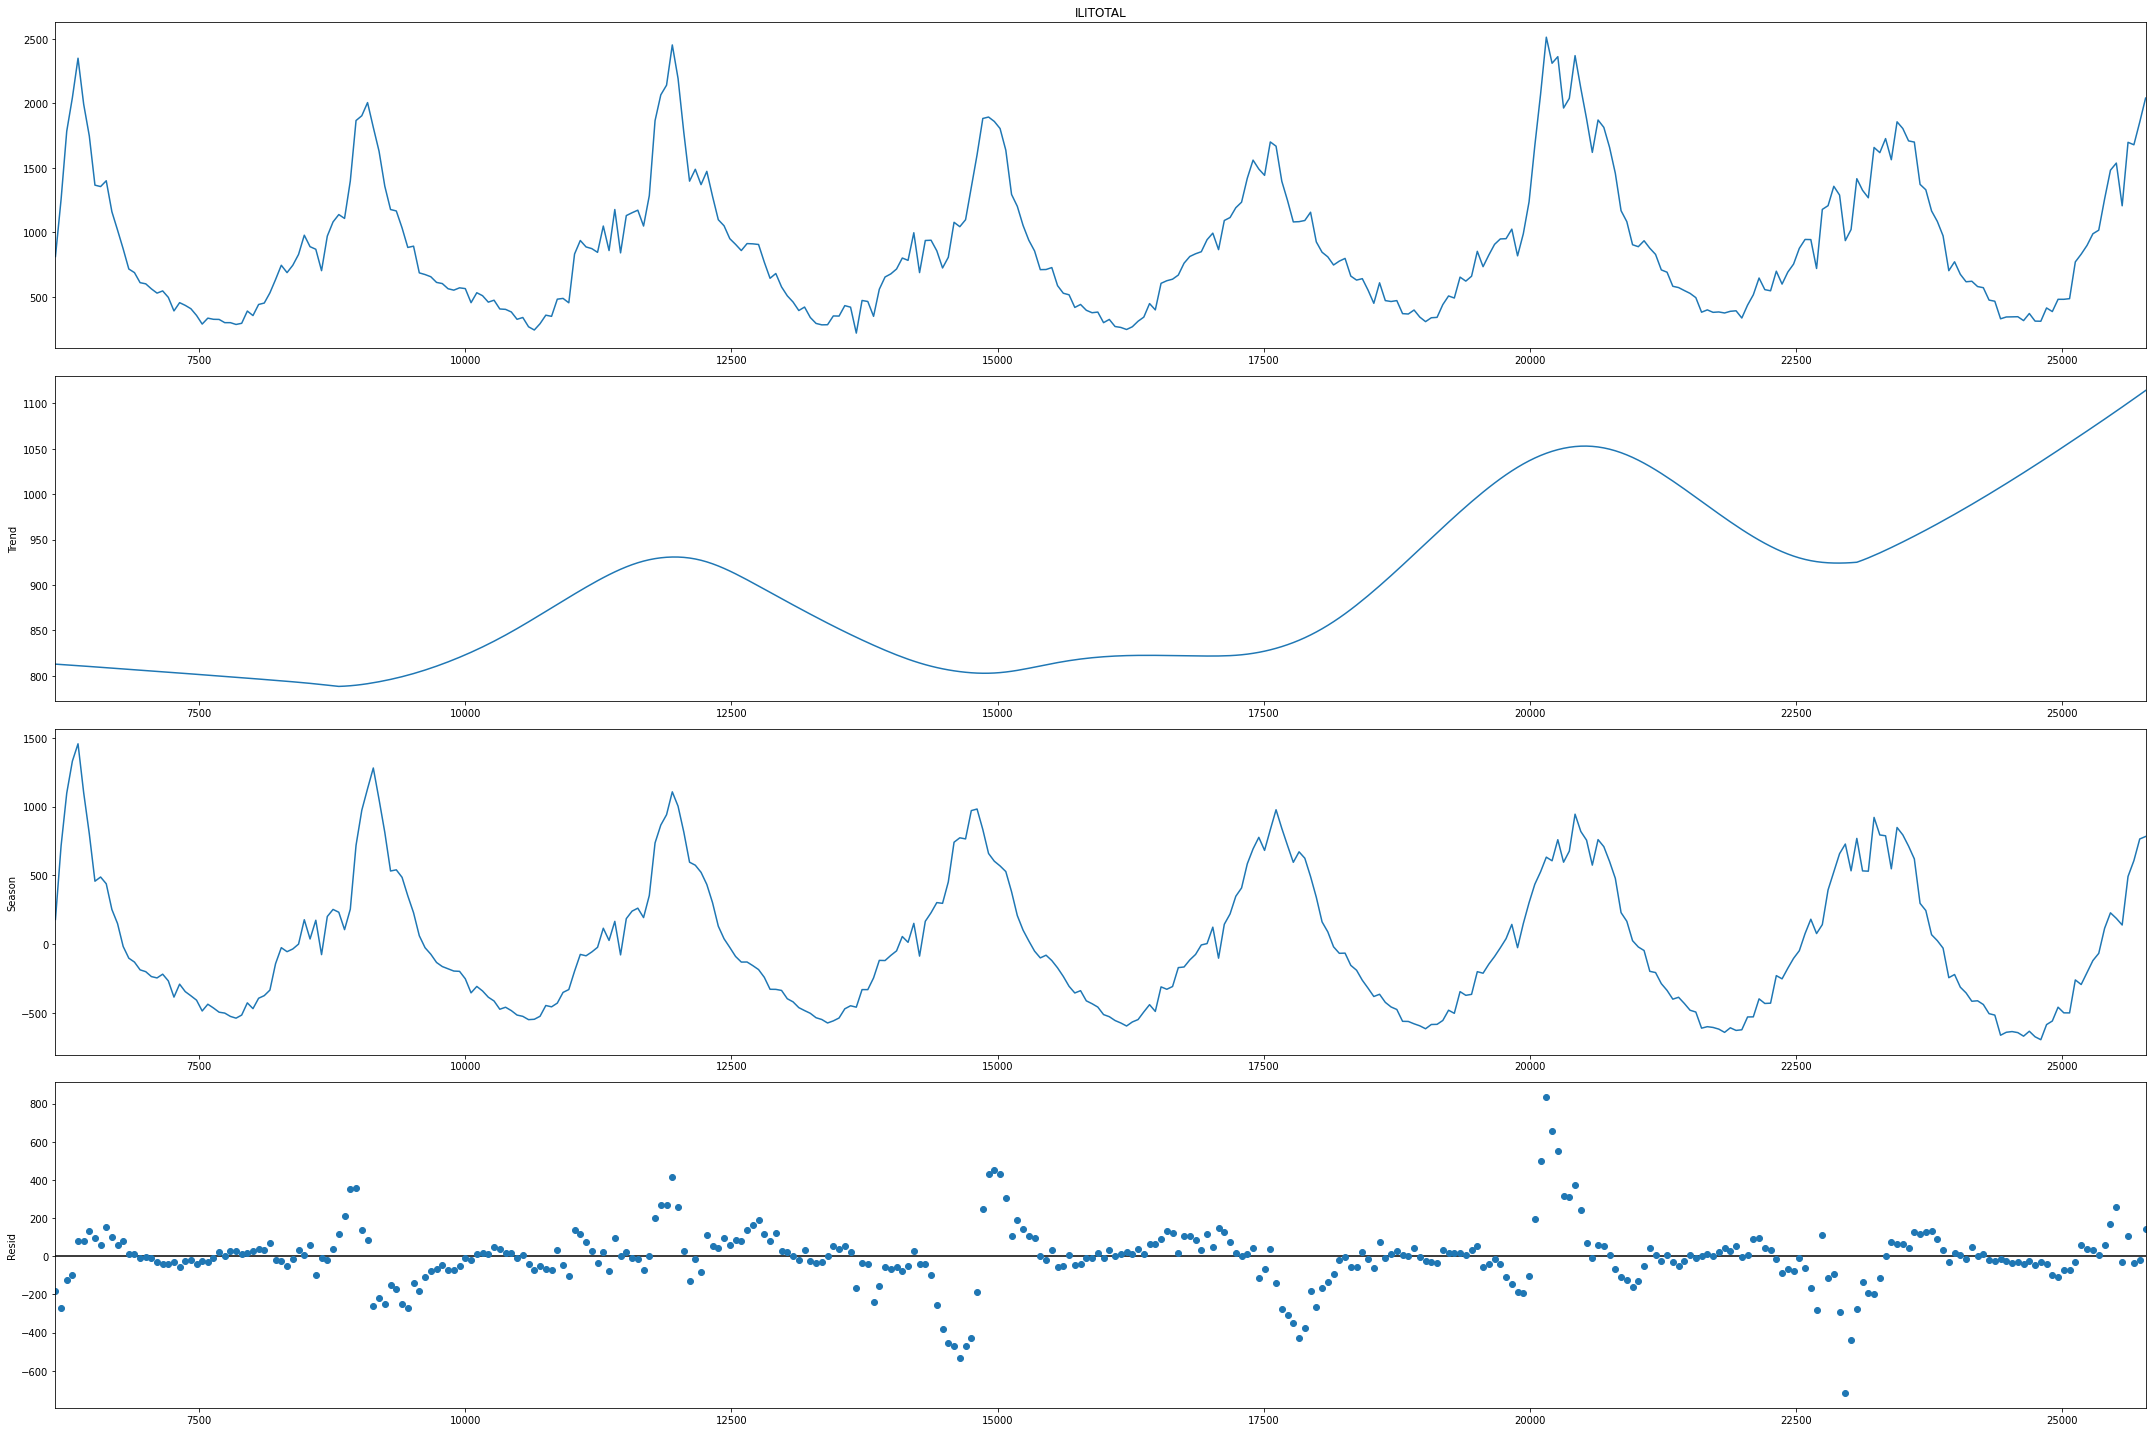

In [58]:
res = STL(ts_df["ILITOTAL"], period=52).fit()
res.plot()
plt.show()

**Residual analysis**

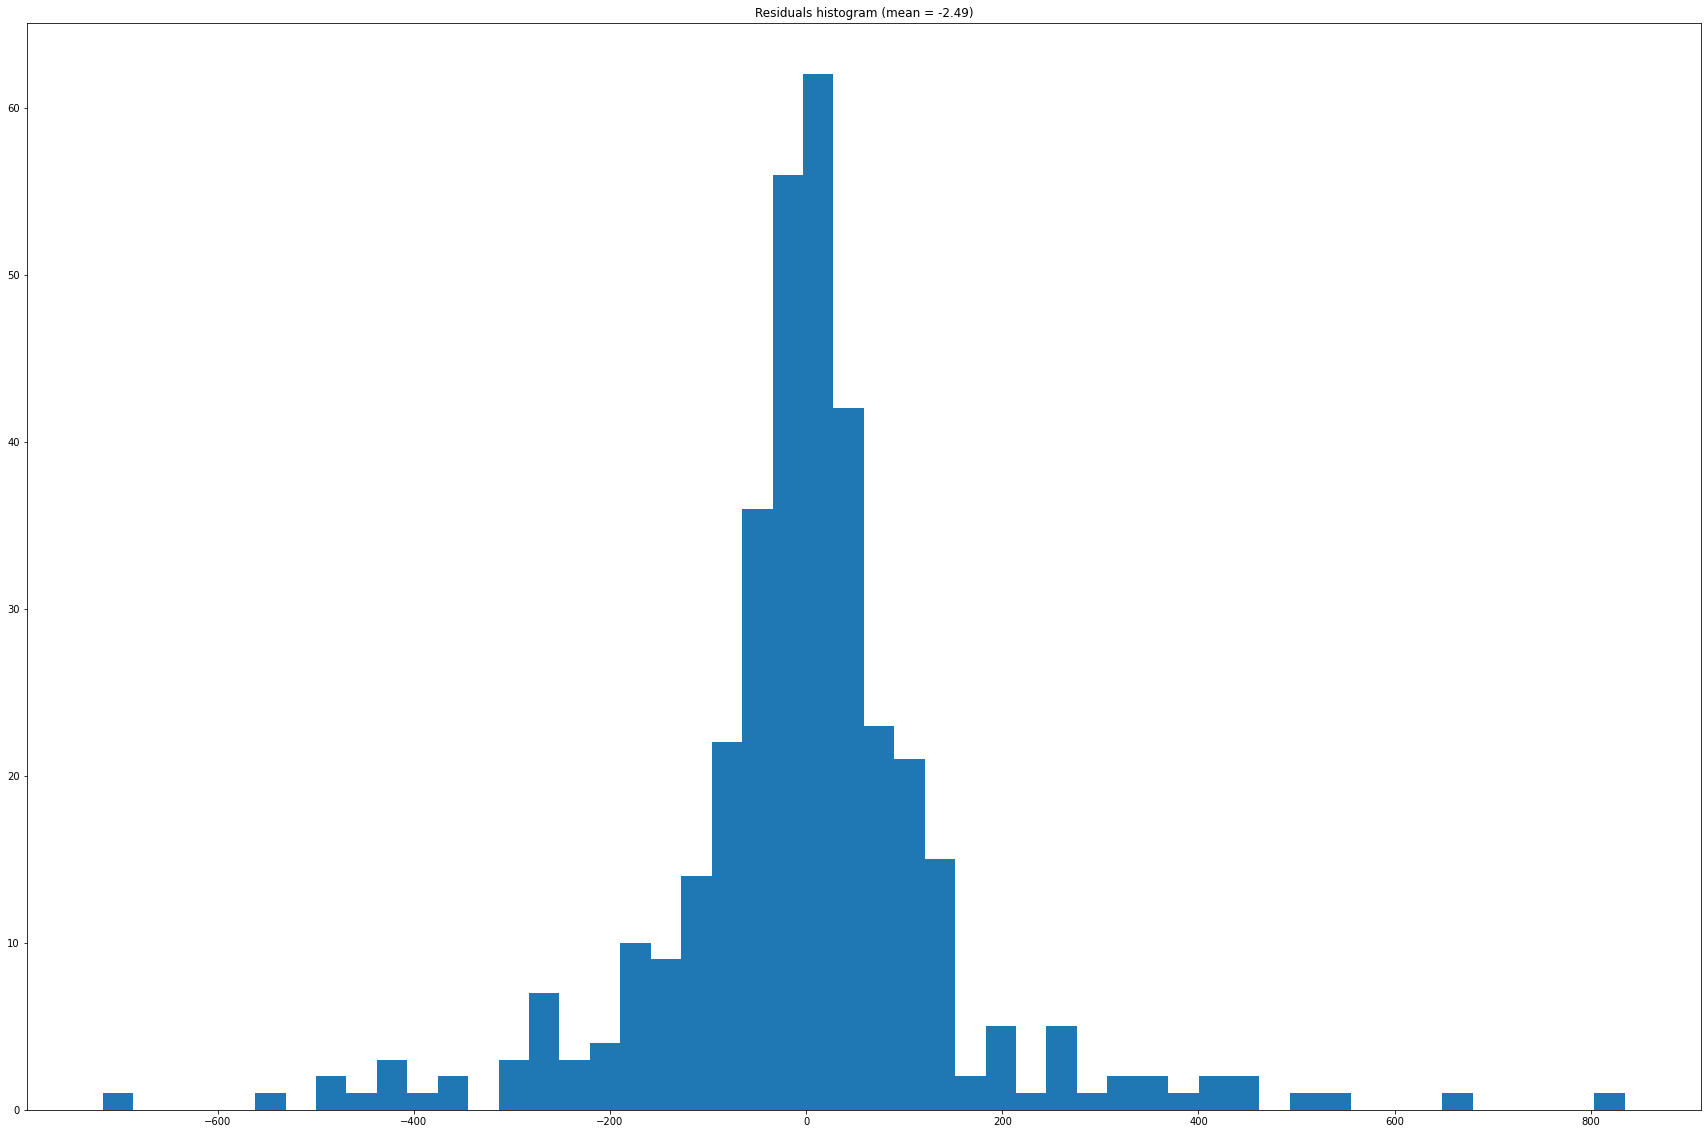

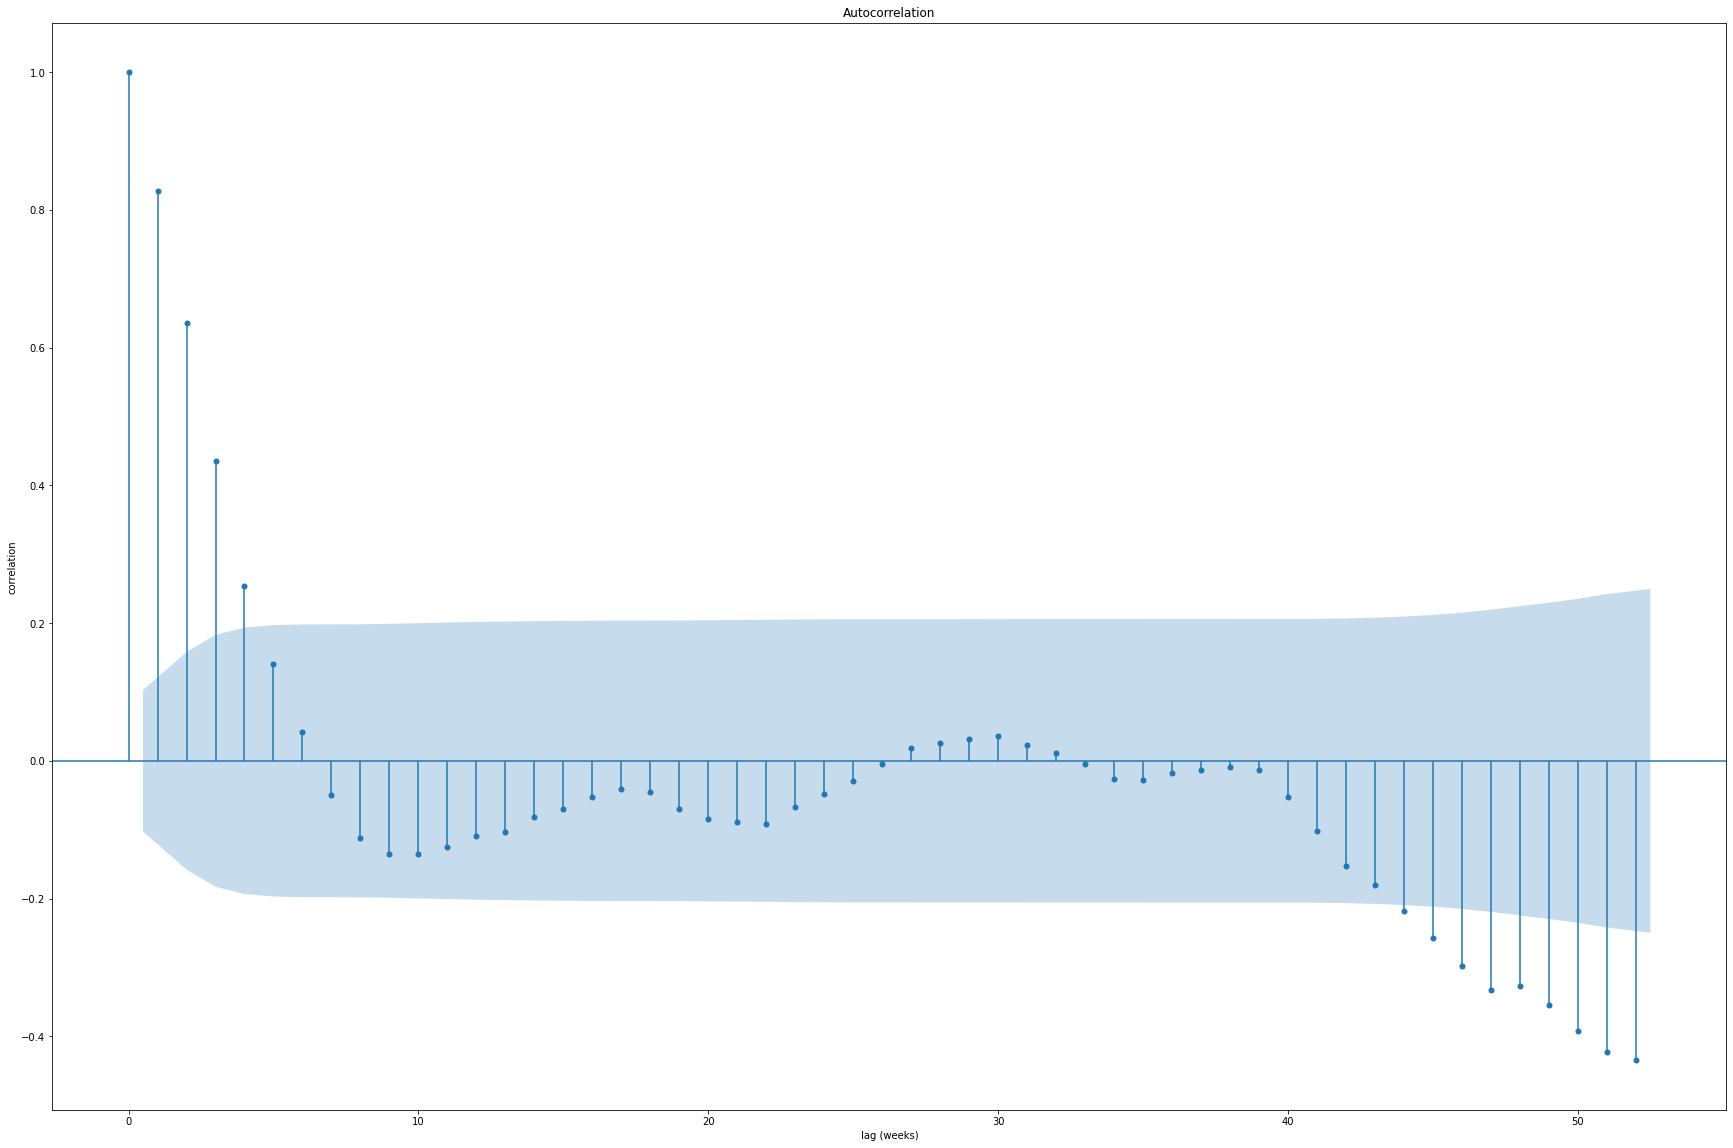

In [60]:
res_mean = np.mean(res.resid)
plt.hist(res.resid, bins=50)
plt.title(f"Residuals histogram (mean = {res_mean: 0.2f})")
plt.show()

plot_acf(res.resid, lags=52)
plt.xlabel("lag (weeks)")
plt.ylabel("correlation")
plt.show()

**Transformations**

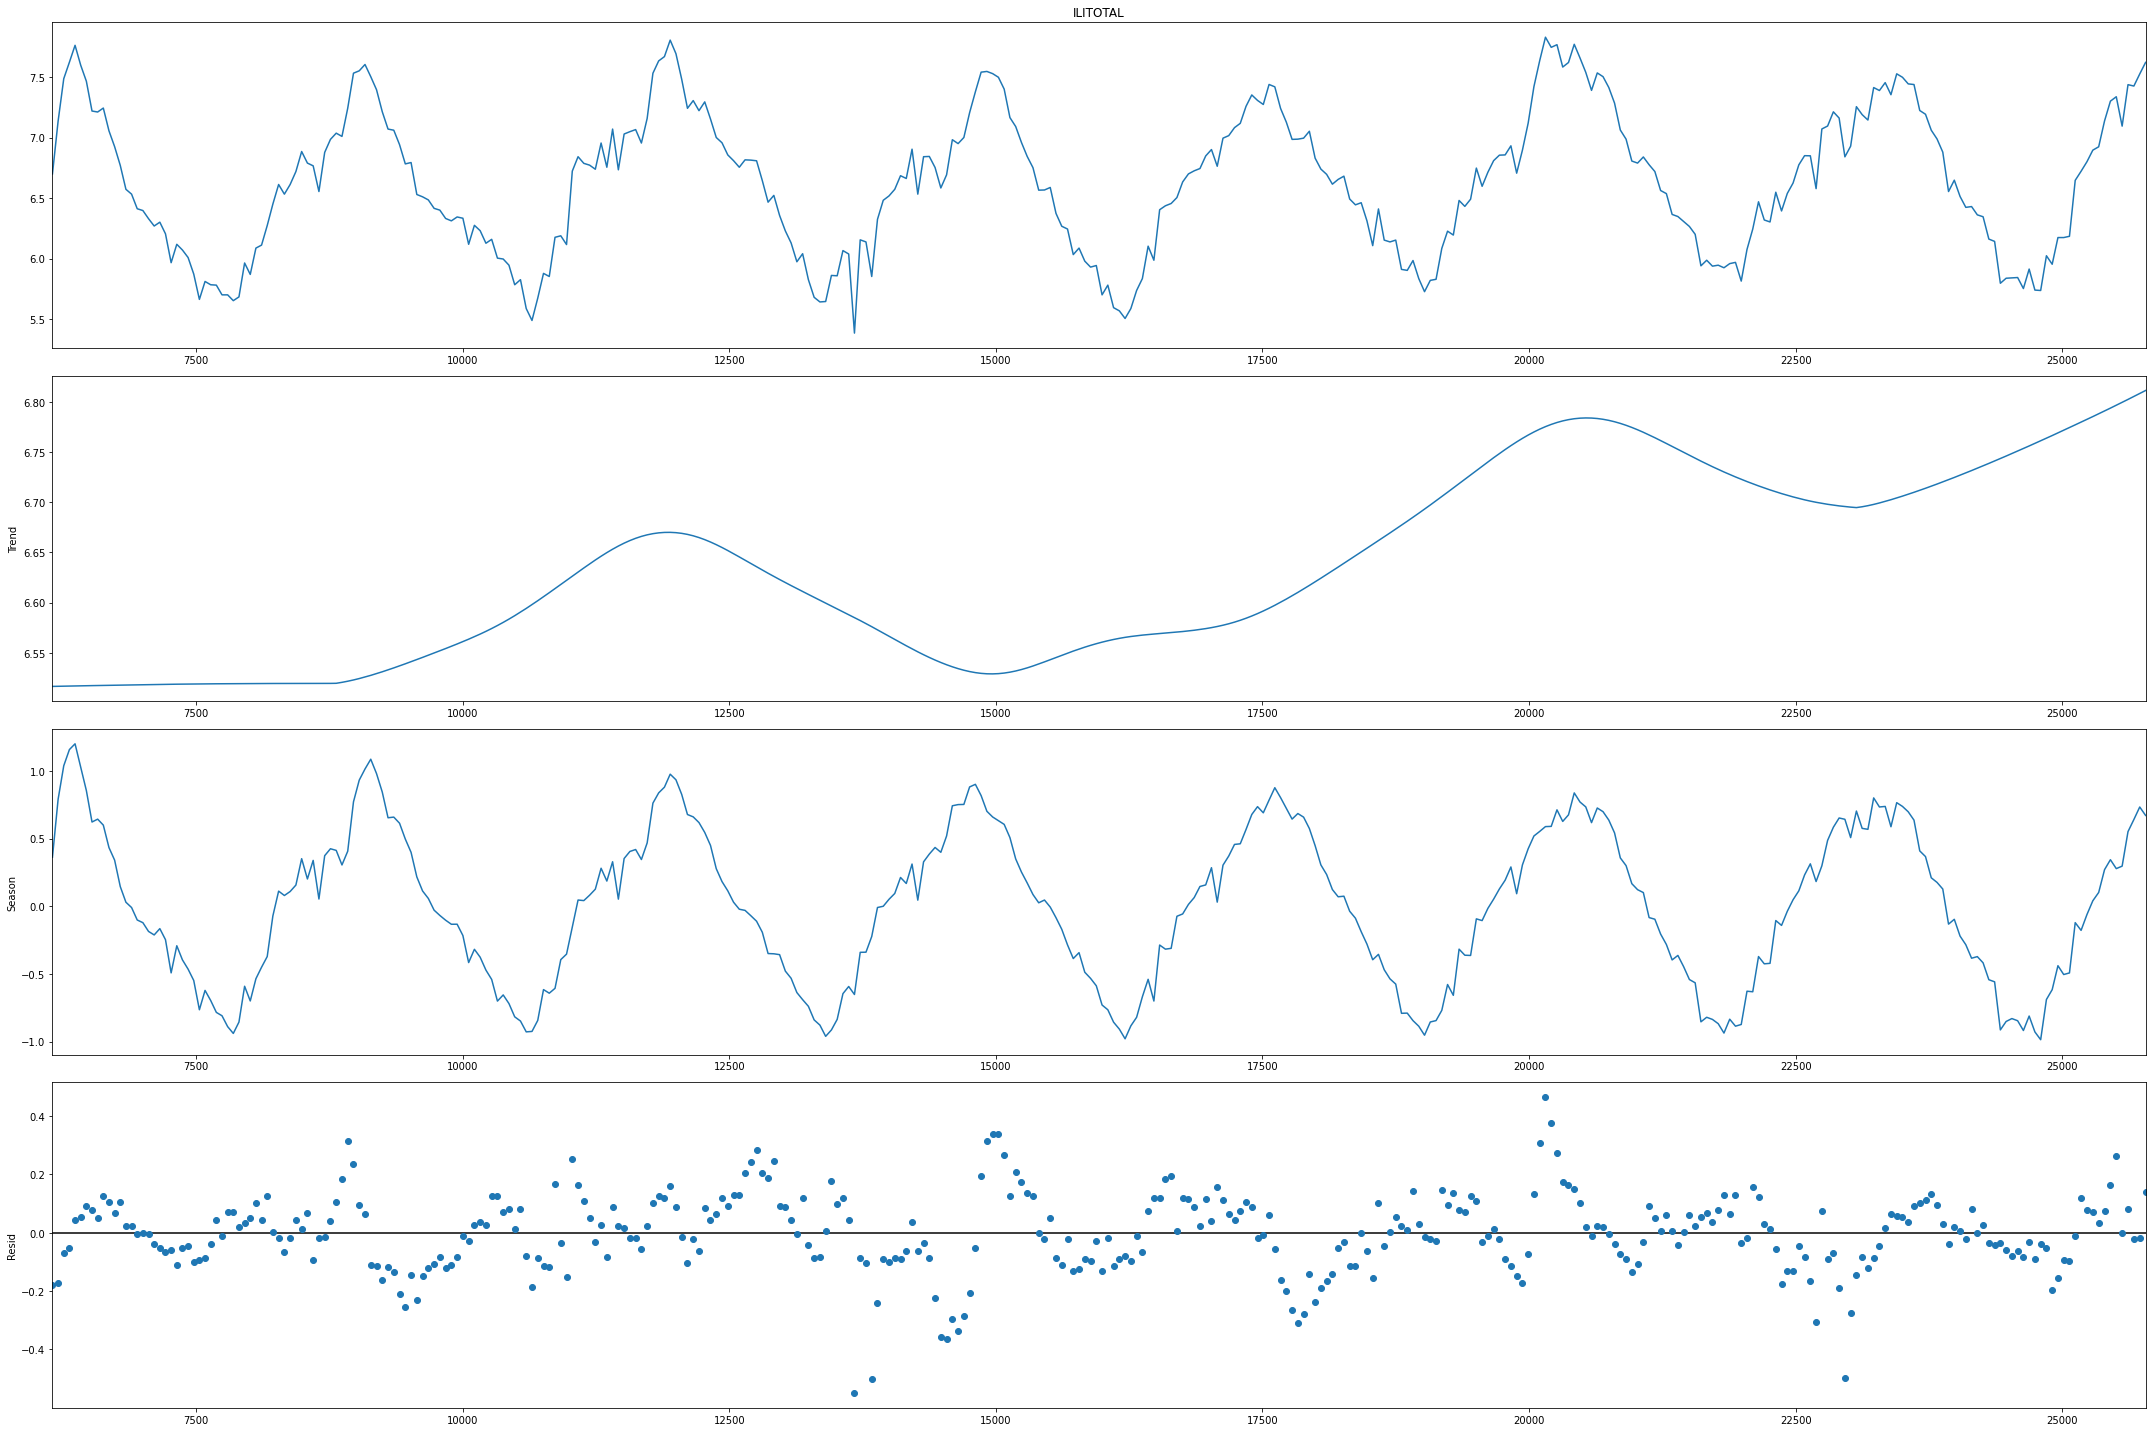

In [61]:
res = STL(np.log(ts_df["ILITOTAL"]), period=52).fit()
res.plot()
plt.show()

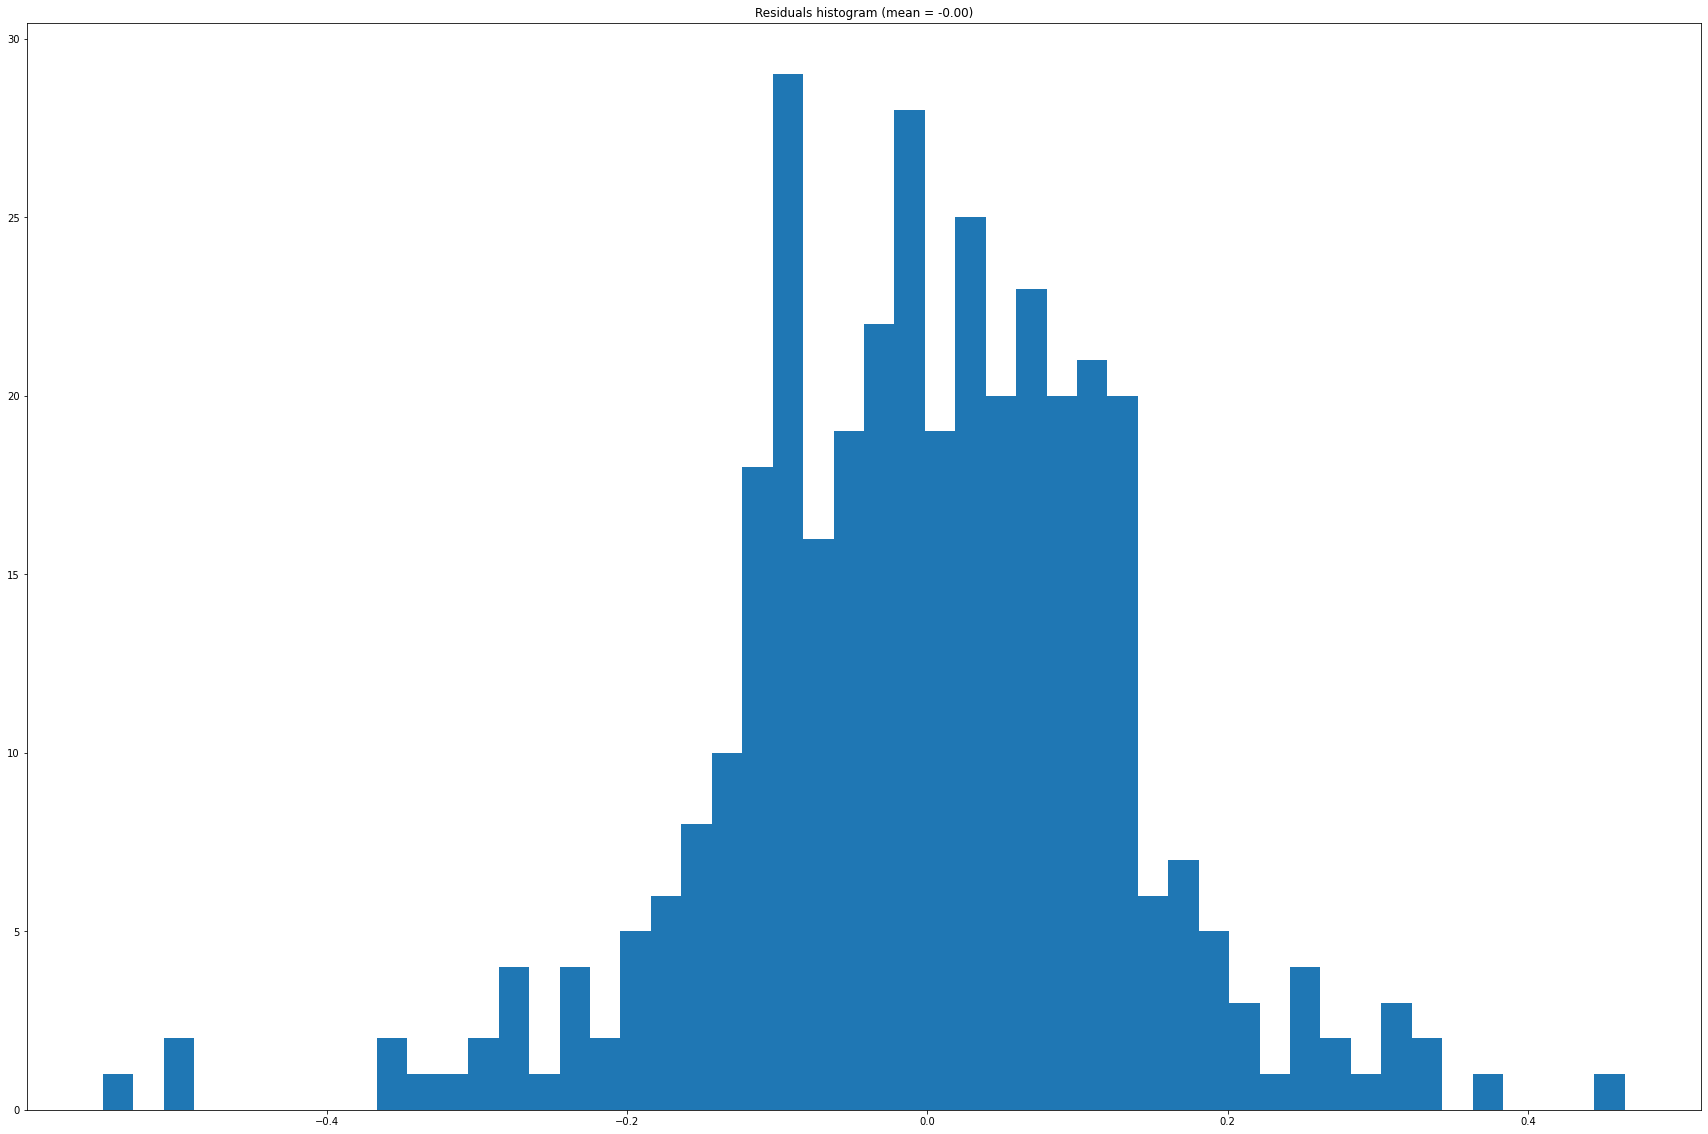

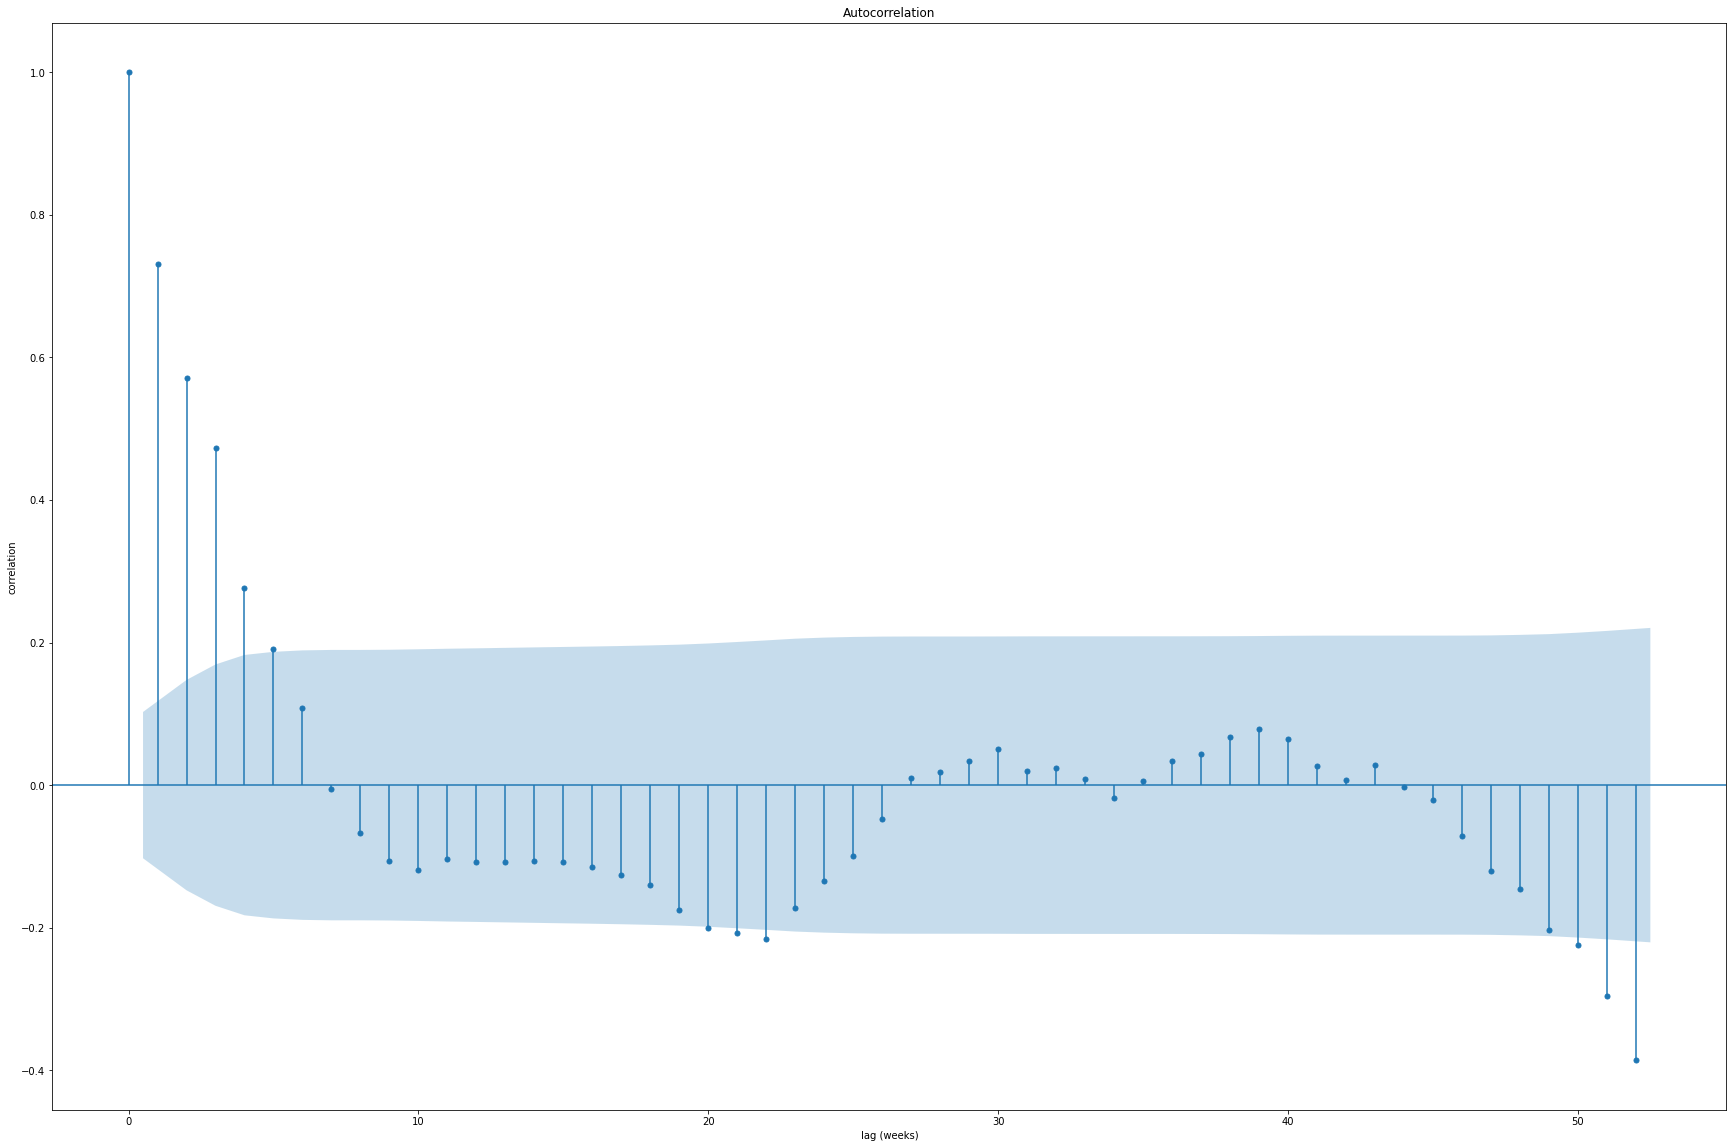

In [62]:
res_mean = np.mean(res.resid)
plt.hist(res.resid, bins=50)
plt.title(f"Residuals histogram (mean = {res_mean: 0.2f})")
plt.show()

plot_acf(res.resid, lags=52)
plt.xlabel("lag (weeks)")
plt.ylabel("correlation")
plt.show()